# Voorspel Diabetes 2023

Luca Oldenbeuving, Kaggle = 

Sami Latic, Kaggle = 

## Importeren libraries

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
pd.set_option('display.max_rows', 1000)
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import string
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import RandomizedSearchCV

## Data importeren

In [2]:
train_c = pd.read_csv('train_c (1).csv')
p_id = train_c['p_id']
train = train_c.drop('p_id', axis=1 )
test = pd.read_csv('test_c (1).csv')
p_id2 = test['p_id']
#sub = pd.read_csv('../Untitled Folder/submission.csv')


## Opdracht 1: Exploratieve Data Analyse

In [3]:
train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,98,58,33,190,34.0,0.430,43,0
1,2,112,75,32,0,35.7,0.148,21,0
2,2,108,64,0,0,30.8,0.158,21,0
3,8,107,80,0,0,24.6,0.856,34,0
4,7,136,90,0,0,29.9,0.210,50,0


We zien in deze dataset 9 features.

**Pregnancies** -> Het aantal zwangerschappen per persoon

**Glucose** -> De concentratie glucose in de patient

**BloodPressure** -> Diastolic blood pressure (mm Hg)

**SkinThickness** -> De dikte van de huid in milimeters

**Insulin** -> 2-uur serum insuline (mu U/ml)

**BMI** -> Body Mass Index

**DiabetesPedigreeFunction** -> Diabetes pedigree function

**Age** -> Leeftijd in jaren

**Outcome** -> Of de patient diabetes heeft of niet. 1 betekent dat de patient diabetes heeft, 0 betekent dat de patient geen diabetes heeft.

In [4]:
print("Aantal rijen in de train dataset: ", train.shape)
print("Aantal rijen in de test dataset: ", test.shape)

Aantal rijen in de train dataset:  (614, 9)
Aantal rijen in de test dataset:  (154, 9)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               614 non-null    int64  
 1   Glucose                   614 non-null    int64  
 2   BloodPressure             614 non-null    int64  
 3   SkinThickness             614 non-null    int64  
 4   Insulin                   614 non-null    int64  
 5   BMI                       614 non-null    float64
 6   DiabetesPedigreeFunction  614 non-null    float64
 7   Age                       614 non-null    int64  
 8   Outcome                   614 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 43.3 KB


In [6]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,614.0,3.809446,3.375544,0.000,1.000,3.0000,6.0000,15.00
Glucose,614.0,120.465798,31.959619,0.000,99.000,115.0000,140.0000,197.00
BloodPressure,614.0,68.903909,19.933385,0.000,62.000,72.0000,80.0000,114.00
SkinThickness,614.0,20.456026,16.063105,0.000,0.000,23.0000,32.0000,99.00
Insulin,614.0,81.250814,116.947384,0.000,0.000,27.0000,130.0000,744.00
BMI,614.0,31.929642,8.136791,0.000,27.400,32.1500,36.5000,67.10
DiabetesPedigreeFunction,614.0,0.468096,0.329203,0.078,0.238,0.3655,0.6285,2.42
Age,614.0,33.265472,11.851427,21.000,24.000,29.0000,41.0000,72.00
Outcome,614.0,0.342020,0.474773,0.000,0.000,0.0000,1.0000,1.00


Hier zijn we een aantal opmerkelijke waardes. We zien dat Glucose, Bloodpressure, Skinthickness, Insuline en BMI nul waardes heeft. Dit is bij allen niet mogelijk, aangezien je zonder deze kenmerken geen levend mens kan zijn.

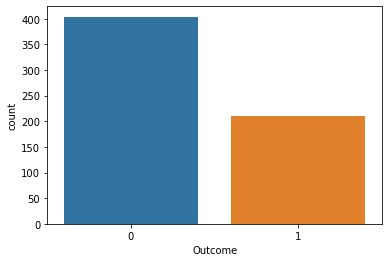

In [7]:
from itertools import cycle
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

sns.countplot(train['Outcome'])
plt.show()

In [8]:
train['Outcome'].value_counts()

0    404
1    210
Name: Outcome, dtype: int64

De distributie van de dependant variable is in dit dataset niet skewed of imbalanced. Er is geen officiele regel wanneer een dataset imbalanced is. 'However, a common rule of thumb is that if the minority class in your dataset constitutes less than 10-20% of your total data, it can be considered imbalanced.' *(Determining whether a dataset is imbalanced or not, z.d.)*



## Null waardes weghalen

In [9]:
train[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = train[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.nan)
test[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']] = test[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']].replace(0, np.nan)

In [10]:
col = list(train.columns)
categorical_features = []
numerical_features = []
for i in col:
    if len(train[i].unique()) > 6:
        numerical_features.append(i)
    else:
        categorical_features.append(i)

print('Categorical Features :',*categorical_features)
print('Numerical Features :',*numerical_features)

Categorical Features : Outcome
Numerical Features : Pregnancies Glucose BloodPressure SkinThickness Insulin BMI DiabetesPedigreeFunction Age


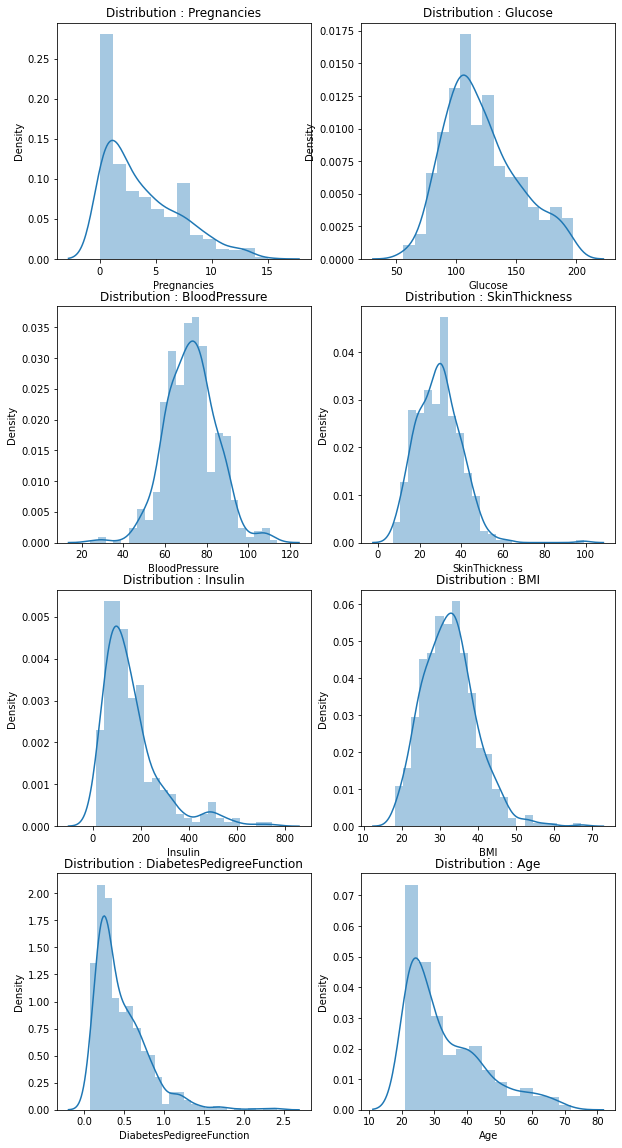

In [11]:
fig, ax = plt.subplots(nrows = 4,ncols = 2,figsize = (10,20))
for i in range(len(numerical_features)):
    plt.subplot(4,2,i+1)
    sns.distplot(train[numerical_features[i]])
    title = 'Distribution : ' + numerical_features[i]
    plt.title(title)
plt.show()

- **Pregnancies**, **Insulin**, **DiabetesPedigreeFunction** en **Age** vertonen een **positieve of rechts scheve** gegevensverdeling. 
- **Bloeddruk** en **SkinThickness** vertonen een **bimodale gegevensverdeling**.
- De gegevensverdelingen van Glucose en BMI zijn enigszins lastig te interpreteren. Dit komt doordat ze bijna een **normale verdeling** of een **bimodale verdeling** lijken te vertonen. Dit wordt veroorzaakt door de kleine piek die te zien is op de waarde **0**. 
- Voor dit notebook zullen we deze verdelingen beschouwen als **bimodaal**.

We zien nu hoe de verschillende waardes verdeeld zijn. Om de null waardes te verwijderen moeten we eerst kijken of we de gemiddelde, mediaan of de modus moeten nemen. Dit doen we door te kijken naar de skewness van de variabelen. Ook kunnen we dan zien hoe groot de kurtosis is.

In [12]:
from scipy.stats import skew
for col in train.drop('Outcome', axis = 1).columns:
    print("Skewness for the column {} is {}".format(col, train[col].skew()))

Skewness for the column Pregnancies is 0.8963315104115814
Skewness for the column Glucose is 0.5576675590409781
Skewness for the column BloodPressure is 0.05708462866086844
Skewness for the column SkinThickness is 0.8284566904662104
Skewness for the column Insulin is 1.9114232642462705
Skewness for the column BMI is 0.640198876348773
Skewness for the column DiabetesPedigreeFunction is 1.8769022757390479
Skewness for the column Age is 1.1239855864706296


De kolommen Pregnancies, Glucose, BloodPressure, SkinThickness, BMI en Age zijn **niet erg geskewed**. Ze wijken niet veel af van de normale verdeling. De kolommen Insulin en DiabetesPedigreeFunction zijn **erg geskewed**. Ze hebben een skew van >1.5.

0 waarden die niet geskewed zijn worden gevuld met het gemiddelde van de kolommen.
0 waarden die wel geskewed zijn worden gevuld met de mediaan.

In [13]:
train['Insulin'] = train['Insulin'].fillna(train['Insulin'].median()) # DiabetesPedigreeFunction heeft geen 0 waarden

for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']:
    train[col] = train[col].fillna(train[col].mean())

#### Zelfde voor de test dataset

In [14]:
from scipy.stats import skew
for col in test.columns:
    print("Skewness for the column {} is {}".format(col, test[col].skew()))

Skewness for the column p_id is -0.045476671297433116
Skewness for the column Pregnancies is 0.9379958953973725
Skewness for the column Glucose is 0.43213606869133103
Skewness for the column BloodPressure is 0.42791149755976904
Skewness for the column SkinThickness is 0.04358273933246738
Skewness for the column Insulin is 3.4340204307191167
Skewness for the column BMI is 0.3988386036419412
Skewness for the column DiabetesPedigreeFunction is 2.092732726485556
Skewness for the column Age is 1.1622103757967737


In [15]:
test['Insulin'] = test['Insulin'].fillna(test['Insulin'].median()) # DiabetesPedigreeFunction heeft geen 0 waarden

for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']:
    test[col] = test[col].fillna(test[col].mean())

In [16]:
train.isnull().sum()
test.isnull().sum()

p_id                        0
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

In [17]:
def gemiddelde(var):
    """
    Een functie die het gemiddelde zal teruggeven van de waarden in de 'var'-kolom, 
    afhankelijk van of de persoon diabetes heeft of niet.
    """
    return pd.DataFrame(train.groupby('Outcome').mean()[var])

In [18]:
def distplot(col_name):
    """
    Een functie die de verdeling van de kolom 'col_name' 
    afzonderlijk zal plotten voor mensen met diabetes en mensen zonder diabetes.
    """
    plt.figure()
    ax = sns.distplot(train[col_name][train.Outcome == 1], color ="red", rug = True)
    sns.distplot(train[col_name][train.Outcome == 0], color ="lightblue",rug = True)
    plt.legend(['Diabetes', 'Geen Diabetes'])

Bron: Data II

### Pregnancies

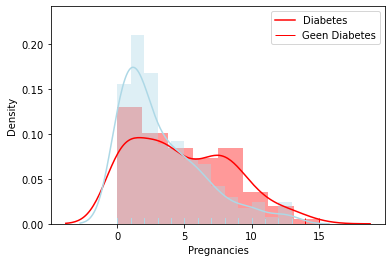

In [19]:
distplot('Pregnancies')

In [20]:
gemiddelde('Pregnancies')

,Pregnancies
Outcome,
0,3.267327
1,4.852381


We zien hier dat mensen met meer Pregnancies vaker diabetes hebben.

### Glucose

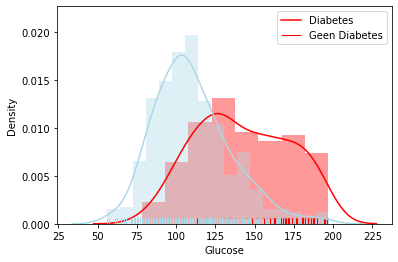

In [21]:
distplot('Glucose')

In [22]:
gemiddelde('Glucose')

,Glucose
Outcome,
0,110.422691
1,142.096456


Mensen met diabetes hebben vaak een hoger glucose. Uit de gegevens van de **Glucosegroep** blijkt dat de vroege waarden een zeer laag aantal diabetesgevallen laten zien. De gevallen nemen vervolgens toe en blijven constant vanaf **125** (20x5) tot **180** (39x5).

### Insulin


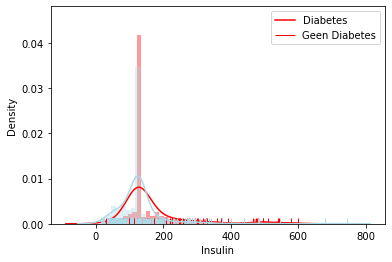

In [23]:
distplot('Insulin')

In [24]:
gemiddelde('Insulin')

,Insulin
Outcome,
0,130.650990
1,166.214286


Mensen met diabetes hebben vaak een hogere insuline waarde.

### BloodPressure

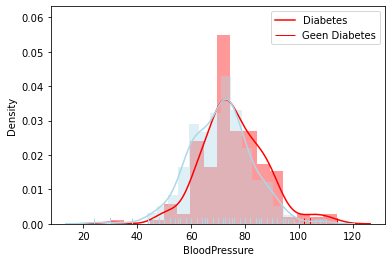

In [25]:
distplot('BloodPressure')

In [26]:
gemiddelde('BloodPressure')

,BloodPressure
Outcome,
0,70.948563
1,75.682766


Mensen met diabetes hebben vaker een hogere bloeddruk. Het bereik van waarden voor **BloodPressure** tussen **60 en 90 mmHg** toont een hoog aantal diabetespatiënten aan.

### Skin Thickness

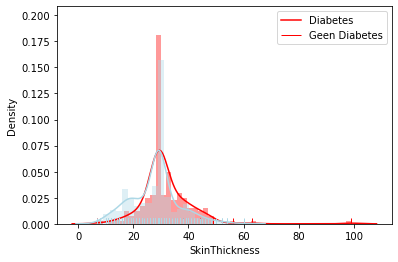

In [27]:
distplot('SkinThickness')

In [28]:
gemiddelde('SkinThickness')

,SkinThickness
Outcome,
0,27.928909
1,31.672536


**Huiddikte** toont een zeer laag aantal diabetesgevallen voor alle waarden. Van die waarden vertonen 24 tot 42 enkele opvallende pieken in het aantal diabetesgevallen.

### Een paar visualisaties voor betere indruk van de data

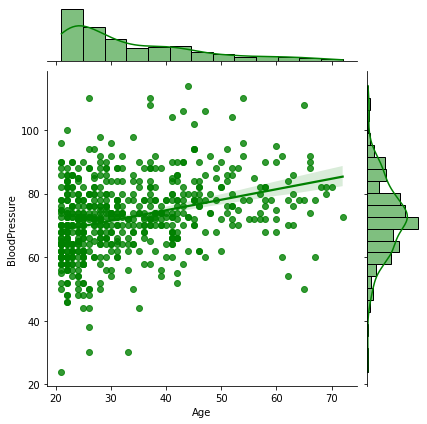

In [29]:
sns.jointplot(x='Age',y='BloodPressure', data=train, kind = 'reg', color = 'green')

Wanneer je ouder wordt, stijgt je bloeddruk.

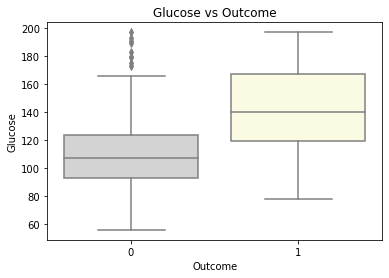

In [30]:
my_pal = {0: "lightgrey", 1: "lightyellow"}
sns.boxplot(x = 'Outcome', y = 'Glucose', data = train, palette = my_pal)
plt.title('Glucose vs Outcome')
plt.show()

Wanneer je **glucose** hoger ligt, heb je vaker **diabetes**.

In [31]:
train.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.119166,0.221029,0.052710,0.035671,0.019085,-0.022406,0.529585,0.222939
Glucose,0.119166,1.000000,0.248581,0.210825,0.423187,0.224476,0.157264,0.250404,0.494147
BloodPressure,0.221029,0.248581,1.000000,0.152262,0.047674,0.288150,0.007743,0.325883,0.186998
SkinThickness,0.052710,0.210825,0.152262,1.000000,0.181533,0.549367,0.103679,0.113026,0.200384
Insulin,0.035671,0.423187,0.047674,0.181533,1.000000,0.202816,0.142310,0.074660,0.193302
BMI,0.019085,0.224476,0.288150,0.549367,0.202816,1.000000,0.138444,0.020889,0.292495
DiabetesPedigreeFunction,-0.022406,0.157264,0.007743,0.103679,0.142310,0.138444,1.000000,0.040877,0.182245
Age,0.529585,0.250404,0.325883,0.113026,0.074660,0.020889,0.040877,1.000000,0.233461
Outcome,0.222939,0.494147,0.186998,0.200384,0.193302,0.292495,0.182245,0.233461,1.000000


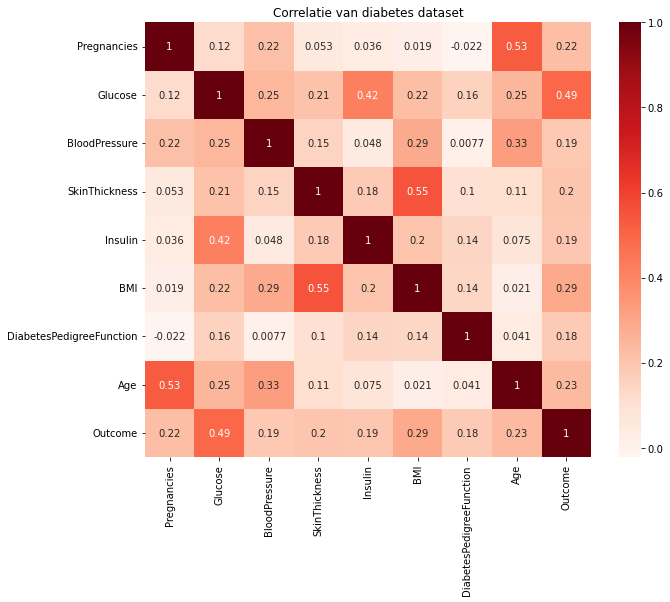

In [32]:
plt.figure(figsize=(10, 8))
sns.heatmap(train.corr(), cmap="Reds", annot=True)
plt.title('Correlatie van diabetes dataset')
plt.show()

Elke variabelen in onze dataset is vrij zwak gecorreleerd met elkaar. Dit haalt het begrip **multicollinearity** weg. Uitleg

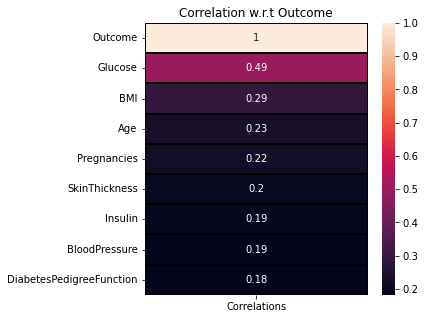

In [33]:
corr = train.corrwith(train['Outcome']).sort_values(ascending = False).to_frame()
corr.columns = ['Correlations']
plt.subplots(figsize = (5,5))
sns.heatmap(corr,annot = True, linewidths = 0.4,linecolor = 'black');
plt.title('Correlation w.r.t Outcome');

### ANOVA toets om te kijken of alle kolommen wel nodig zijn

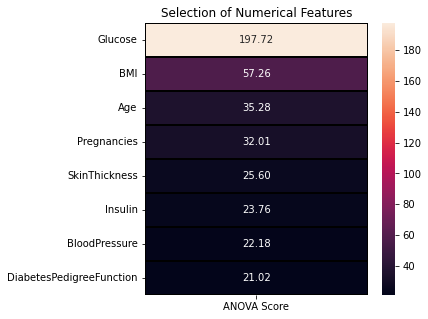

In [34]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

features = train.loc[:,numerical_features]
target = train.loc[:,categorical_features]

best_features = SelectKBest(score_func = f_classif,k = 'all')
fit = best_features.fit(features,target)

featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score']) 

plt.subplots(figsize = (5,5))
sns.heatmap(featureScores.sort_values(ascending = False,by = 'ANOVA Score'),annot = True,linewidths = 0.4,linecolor = 'black',fmt = '.2f');
plt.title('Selection of Numerical Features');

Volgens de ANOVA test zijn de kolommen met hogere waarden belangrijk. Aangezien de laagste waarde 21 is, droppen we geen kolommen.

### Beschrijf wat wordt bedoeld met het standaardiseren van de data. Geef aan in welke gevallen dit gewenst is. Beargumenteer of het waarde toevoegt voor deze dataset en voer eventueel standaardisatie uit.

We hebben 2 opties voor data scaling: 1) **Normalisatie** 2) **Standaardisatie**. Aangezien de meeste algoritmen aannemen dat de gegevens normaal (Gaussian) verdeeld zijn, wordt **normalisatie** uitgevoerd voor functies waarvan de gegevens geen normale verdeling vertonen, en wordt **standaardisatie** uitgevoerd voor functies die normaal verdeeld zijn en waarvan de waarden aanzienlijk groter of kleiner zijn in vergelijking met andere functies.

Normalisatie: **Pregnancies**, **Insulin**, **DiabetesPedigreeFunction** en **Age** worden genormaliseerd, omdat ze een rechts scheve gegevensverdeling vertoonden. **BloodPressure**, **SkinThickness**, **Glucose** en **BMI** vertonen een bimodale gegevensverdeling.

Standaardisatie: Geen van de functies wordt gestandaardiseerd voor de bovenstaande gegevens.

## Opdracht 2 - Evaluatie

#### Deze opdracht heeft betrekking op een bepaalde vorm van machine learning. Welke vorm is dit? Licht het antwoord toe

Deze dataset heeft betrekking op supervised machine learning, met name voor classificatie.

Supervised machine learning is een type machine learning waarbij het model wordt getraind op een gelabelde dataset, wat betekent dat de juiste antwoorden of labels al bekend zijn. In het geval van de Diabetes Diataset zijn de labels of uitkomsten voor elke patiënt in de dataset bekend (in de training set), wat betekent dat het een supervised machine learning-probleem is.

Het doel van dit soort machine learning is om een model te bouwen dat in staat is om nieuwe, ongelabelde gegevens te classificeren op basis van de patronen die het heeft geleerd van de gelabelde dataset. 

#### Geef aan met welke “metrics”, voor deze vorm van machine learning, bepaalt kan worden hoe goed een model presteert. Toon de uitkomsten op deze metrics aan de hand van een zelf te kiezen machine learning algoritme. 

**Accuracy**: Dit is het aantal correct geclassificeerde voorbeelden gedeeld door het totale aantal voorbeelden in de testdataset. Het geeft aan hoeveel procent van de voorspellingen correct is.

**Precision**: Precisie meet hoeveel van de positieve voorspellingen daadwerkelijk correct zijn. Het wordt berekend als het aantal ware positieven gedeeld door het aantal voorspelde positieven (ware positieven + valse positieven).

**Recall**: Recall meet hoeveel van de werkelijke positieve voorbeelden correct zijn voorspeld. Het wordt berekend als het aantal ware positieven gedeeld door het aantal werkelijke positieven (ware positieven + valse negatieven).

**F1-score**: De F1-score is de harmonische gemiddelde van precisie en recall. Het biedt een evenwicht tussen precisie en recall en is handig wanneer er een onbalans is tussen de klassen.

**ROC Curve** en **AUC-ROC**: De Receiver Operating Characteristic (ROC) curve toont de trade-off tussen de ware positieve snelheid (TPR) en de valse positieve snelheid (FPR) voor verschillende drempelwaarden. Het gebied onder de ROC-curve (AUC-ROC) geeft een samenvattende maat voor de prestaties van het model.

**Confusion Matrix**: De confusion matrix toont een gedetailleerde weergave van de resultaten, inclusief het aantal ware positieven, ware negatieven, valse positieven en valse negatieven. (Agrawal, 2023)

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelBinarizer , StandardScaler ,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , accuracy_score,plot_confusion_matrix

X = train.drop('Outcome', axis = 1)
y = train['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42, stratify = y)

In [38]:
from sklearn.metrics import recall_score
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_rep)
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

Accuracy: 0.8181818181818182
Confusion Matrix:
[[93  8]
 [20 33]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87       101
           1       0.80      0.62      0.70        53

    accuracy                           0.82       154
   macro avg       0.81      0.77      0.79       154
weighted avg       0.82      0.82      0.81       154

Recall: 0.6226415094339622


In de cel hierboven heb ik een simpele Logistic Regression uitgevoerd. De metrics zijn:
- **Accuracy**:  In mijn geval is de accuracy ongeveer 0,8182 of 81,82%. Dit betekent dat ongeveer 81,82% van de voorspellingen gemaakt door jouw logistic regression-model op de testgegevens correct is.
- **Confusion Matrix**: De waarde linksboven, 93, vertegenwoordigt het aantal ware negatieven (TN). Dit zijn gevallen waarin het model correct de negatieve klasse heeft voorspeld. De waarde rechtsboven, 8, vertegenwoordigt het aantal valse positieven (FP). Dit zijn gevallen waarin het model ten onrechte de positieve klasse heeft voorspeld terwijl het de negatieve klasse had moeten voorspellen. De waarde linksonder, 20, vertegenwoordigt het aantal valse negatieven (FN). Dit zijn gevallen waarin het model ten onrechte de negatieve klasse heeft voorspeld terwijl het de positieve klasse had moeten voorspellen. De waarde rechtsonder, 33, vertegenwoordigt het aantal ware positieven (TP). Dit zijn gevallen waarin het model correct de positieve klasse heeft voorspeld.
- **F1-score**: De F1-score is het harmonisch gemiddelde van precisie en recall. Precisie is het ratio van ware positieven ten opzichte van de som van ware positieven en valse positieven. Recall (ook wel gevoeligheid genoemd) is het ratio van ware positieven ten opzichte van de som van ware positieven en valse negatieven. De F1-score houdt rekening met zowel precisie als recall en is nuttig wanneer je een balans wilt vinden tussen valse positieven en valse negatieven. In mijn geval is de F1-score ongeveer 0,82. Dit is een redelijk goede F1-score en geeft aan dat er een balans is tussen precisie en recall in de voorspellingen van mijn model.
- **Recall**: Recall, ook bekend als sensitiviteit, meet het vermogen van een classificatiemodel om alle positieve voorbeelden correct te identificeren, en het wordt berekend door het aantal ware positieven te delen door de som van ware positieven en valse negatieven. Een recall-waarde van ongeveer 0,6226 (of 62,26%) betekent dat ongeveer 62,26% van alle werkelijke positieve voorbeelden correct is geïdentificeerd door het model; dit is vooral belangrijk in situaties waar het cruciaal is om geen positieve gevallen te missen, zelfs als dit kan leiden tot enkele valse positieve identificaties.

**Leg uit hoe iedere metric wordt berekend. Gebruik hierbij een confusion matrix.**

**Confusion Matrix**: (Agrawal, 2023)

Een Confusion Matrix is een tabel die de resultaten van de classificatie weergeeft op basis van vier mogelijke uitkomsten: 

- **True Positives (TP)**: Het aantal voorbeelden dat correct is geclassificeerd als positief.
- **False Positives (FP)**: Het aantal voorbeelden dat onjuist is geclassificeerd als positief (terwijl het negatief is).
- **False Negatives (FN)**: Het aantal voorbeelden dat onjuist is geclassificeerd als negatief (terwijl het positief is).
- **True Negatives (TN)**: Het aantal voorbeelden dat correct is geclassificeerd als negatief.

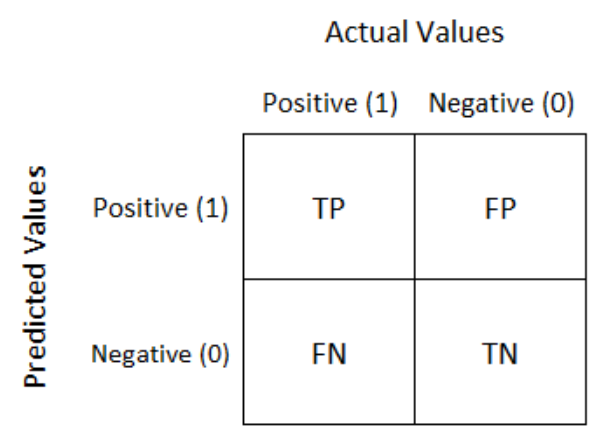

Hier is hoe elke metric wordt berekend met behulp van de confusion matrix:

1. **Accuracy**:
- Accuraatheid meet het percentage correct geclassificeerde voorbeelden ten opzichte van het totale aantal voorbeelden.
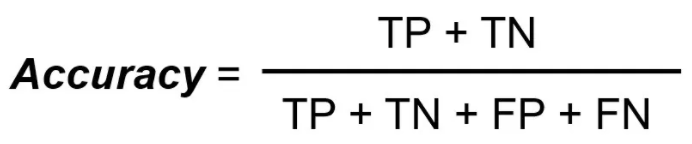

2. **Precision**:
- Precision meet het percentage correct positieve voorspellingen van alle positieve voorspellingen.
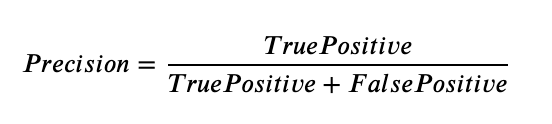

3. **Recall**:
- Recall meet het percentage correct positieve voorspellingen van alle werkelijke positieve voorbeelden.
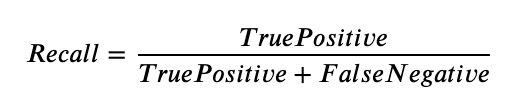

4. **F1-score**:
- De F1-score is het harmonische gemiddelde van precisie en recall. Het geeft een gebalanceerde maat voor de prestaties van het model, rekening houdend met zowel false positives als false negatives.
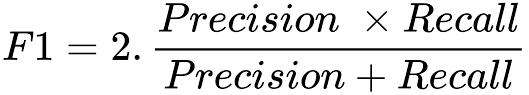

#### Kies een metric die in jullie ogen het meest relevant is en beargumenteer je keuze.

De metric die het meest relevant is in onze ogen is de F1-score. Vanwege de onbalans tussen de klassen, de medische aard van het probleem, en de noodzaak om een evenwicht te vinden tussen het correct identificeren van diabetesgevallen en het minimaliseren van onnodige fouten. De F1-score combineert precisie en recall in een enkele metric en is daarom geschikt om de prestaties van het model te evalueren, rekening houdend met zowel valse positieven als valse negatieven, waardoor het een waardevolle keuze is voor dit diagnostische scenario. (Ook worden de extra punten beoordeelt op de F1-score) (Bajaj, 2023)

## Opdracht 3 - Modelleren

## Logistic Regression

              precision    recall  f1-score   support

           0       0.92      0.82      0.87       114
           1       0.60      0.80      0.69        40

    accuracy                           0.81       154
   macro avg       0.76      0.81      0.78       154
weighted avg       0.84      0.81      0.82       154

Logistic Regression:> 0.8116883116883117


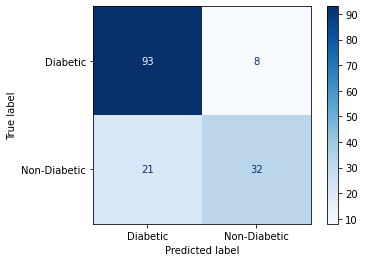

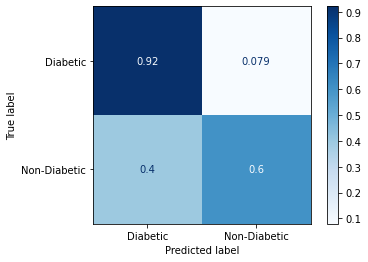

In [39]:
log = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
log.fit(X_train,y_train)
y_pred = log.predict(X_test)
print(classification_report(y_pred,y_test))
print("Logistic Regression:>",accuracy_score(y_pred,y_test))\

plot_confusion_matrix(log,X_test,y_test,display_labels=["Diabetic","Non-Diabetic"],cmap=plt.cm.Blues)
plot_confusion_matrix(log,X_test,y_test,display_labels=["Diabetic","Non-Diabetic"],cmap=plt.cm.Blues,normalize='true')

## Decision Tree

In [40]:
from sklearn.tree import DecisionTreeClassifier


              precision    recall  f1-score   support

           0       0.86      0.81      0.84       107
           1       0.62      0.70      0.66        47

    accuracy                           0.78       154
   macro avg       0.74      0.76      0.75       154
weighted avg       0.79      0.78      0.78       154

DecisionTreeClassifier:> 0.7792207792207793


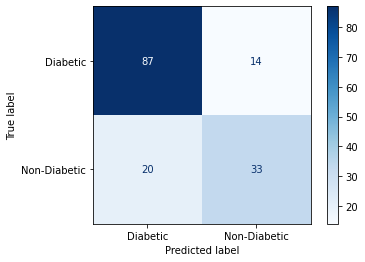

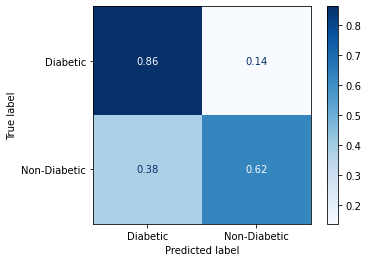

In [41]:
dec =DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=100,
 max_features=1.0, max_leaf_nodes=10, min_samples_leaf=1,
 min_samples_split=2, min_weight_fraction_leaf=0.10,
  random_state=27, splitter='best')
dec.fit(X_train,y_train)
y_pred = dec.predict(X_test)
print(classification_report(y_pred,y_test))
print("DecisionTreeClassifier:>",accuracy_score(y_pred,y_test))

plot_confusion_matrix(dec,X_test,y_test,display_labels=["Diabetic","Non-Diabetic"],cmap=plt.cm.Blues)
plot_confusion_matrix(dec,X_test,y_test,display_labels=["Diabetic","Non-Diabetic"],cmap=plt.cm.Blues,normalize='true')

We know that Decision Tree Classifier is prone to Overfitting, and that's what we have got here. We can see that the train accuracy is 100% but the test accuracy is only 67.71%. We also know that Random Forest Classifier helps to overcome this drawback of Decision Tree Classifer. Let's check that model out.

## Random forest

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

In [43]:

model_grid = RandomForestClassifier(max_depth=9, 
                                    max_features="log2", 
                                    max_leaf_nodes=9, 
                                    n_estimators=25) 
model_grid.fit(X_train, y_train) 
y_pred_grid = model_grid.predict(X_test) 
print(classification_report(y_pred_grid, y_test)) 

              precision    recall  f1-score   support

           0       0.91      0.81      0.86       114
           1       0.58      0.78      0.67        40

    accuracy                           0.80       154
   macro avg       0.75      0.79      0.76       154
weighted avg       0.83      0.80      0.81       154



**Wat is een Random Forest?**

Een random forest is een machine learning-techniek die wordt gebruikt om regressie- en classificatieproblemen op te lossen. Het maakt gebruik van ensemble learning, een techniek die vele classificatoren combineert om oplossingen te bieden voor complexe problemen. 

Een random forest-algoritme bestaat uit veel decision trees. De 'forest' dat gegenereerd wordt door het random forest-algoritme wordt getraind via bagging of bootstrap aggregating. Bagging, ook wel bekend als bootstrap aggregating, is de ensemble learning-methode die doorgaans wordt gebruikt om de variantie binnen een rumoerige dataset te verminderen.

Het (random forest) algoritme bepaalt de uitkomst op basis van de voorspellingen van de decision trees. Het voorspelt door het gemiddelde te nemen van de uitvoer van verschillende bomen. Het verhogen van het aantal bomen verhoogt de precisie van de uitkomst.

**Hoe werkt een Random Forest?**

Random Forest werkt door een set beslisbomen te combineren tot een ensemble.
Elke boom is gebouwd met willekeurige subsets van gegevens. Hierdoor kan het Random Forest-algoritme meer accurate voorspellingen maken dan traditionele machine learning-methoden. Het willekeurige selectieproces helpt de variantie en overfitting binnen het model te verminderen, terwijl het robuuster en bestendiger wordt tegen ruis in de gegevens. (Donges, 2021)

Het proces begint met het voorbereiden van meerdere subsets van de trainingsdata door middel van **bootstrap aggregating**, ook wel bekend als "bagging". Bagging houdt in dat er willekeurig monsters (steekproeven) worden genomen uit de oorspronkelijke trainingsdata met vervanging. Dit betekent dat sommige gegevenspunten meerdere keren in dezelfde subset kunnen voorkomen, terwijl andere helemaal niet worden opgenomen.

Voor elke subset van de trainingsdata wordt een afzonderlijke beslisboom gebouwd. Dit gebeurt met behulp van een beslisboomalgoritme, zoals **CART** (Classification and Regression Trees) of **Gini-index**, om de dataset in verschillende kenmerkensplitsingen op te delen.
Belangrijk is dat bij elke split in de boom slechts een willekeurige subset van de beschikbare kenmerken wordt overwogen. Dit vermindert de correlatie tussen de bomen en voorkomt overfitting. (Yiu, 2021)

Tijdens de training genereert Random Forest meerdere beslisbomen, die worden gebruikt om voorspellingen te doen voor ongeziene gegevenspunten (testinstanties). Bij voorspellingstijd berekent het Random Forest-algoritme het resultaat voor een gegeven testinstantie door het gemiddelde te nemen van de voorspellingen van elke boom.
Dit gemiddelde mechanisme helpt de variantie van het Random Forest-model te verminderen en leidt tot meer accurate voorspellingen.

Ze kunnen nauwkeurig voorspellingen doen met minimaal voorafgaand gegevenspreprocessing en bieden robuuste voorspellende nauwkeurigheid, zelfs in lawaaierige datasets.
Bovendien zijn Random Forests eenvoudig te trainen en schalen ze goed naar grote datasets met duizenden functies of dimensies.

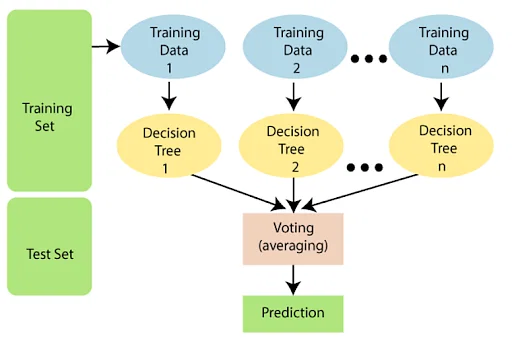

*IMAGE COURTESY: javapoint*

**Leg uit hoe de performance van dit model zich verhoudt tot de performance van andere Tree based modellen**

- Een decision tree is eenvoudiger en gemakkelijker te interpreteren, maar gevoelig voor overfitting, terwijl een random forest complexer is en het risico op overfitting vermindert.

Kijken we naar de decision tree in het notebook zien we duidelijk een geval van overfitting. De train accuracy is 100% en de test accuracy veel lager.

- Een random forest levert doorgaans robuustere en betere prestaties op nieuwe gegevens, en wordt veel gebruikt in verschillende domeinen zoals financiën, gezondheidszorg en diep leren.

- Het belangrijkste verschil tussen random forests en gradient boosting ligt in hoe de beslisbomen worden gemaakt en samengevoegd. In tegenstelling tot random forests worden de beslisbomen in gradient boosting additief opgebouwd, wat betekent dat elke beslisboom één voor één wordt gemaakt en toegevoegd aan het model. (Lok, 2022)


**Bepaal bij welke hyperparameters het model de beste resultaten geeft op degekozen metric.**

Om de beste hyperparameters te bepalen zullen we gebruik maken van een GridSearch met cross-validation. We zullen grid search gebruiken om te zoeken naar de beste hyperparameters voor een Random Forest Classifier in termen van de nauwkeurigheid (accuracy) op de testset. We zullen de volgende hyperparameters afstemmen: (Great Learning Team, 2023)

- n_estimators: Het aantal bomen in het ensemble.
- max_depth: De maximale diepte van elke boom.
- min_samples_split: Het minimum aantal samples dat nodig is om een knoop te splitsen.
- min_samples_leaf: Het minimum aantal samples dat nodig is om een bladknoop te vormen.

In [44]:
#Mogelijkheden voor hyperparameters

param_grid = { 
    'n_estimators': [25, 50, 100, 150], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [3, 6, 9], 
    'max_leaf_nodes': [3, 6, 9], 
} 

In [45]:
random_search = RandomizedSearchCV(RandomForestClassifier(), 
                                   param_grid) 
random_search.fit(X_train, y_train) 
print(random_search.best_estimator_) 

RandomForestClassifier(max_depth=9, max_features=None, max_leaf_nodes=9,
                       n_estimators=25)


**Gebruik nu de Hyperparameters uit de GridSearch voor een hogere f1 score**

              precision    recall  f1-score   support

           0       0.91      0.82      0.86       112
           1       0.62      0.79      0.69        42

    accuracy                           0.81       154
   macro avg       0.77      0.80      0.78       154
weighted avg       0.83      0.81      0.82       154

0.8116883116883117


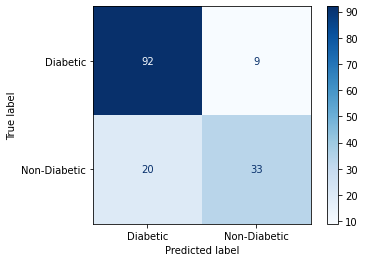

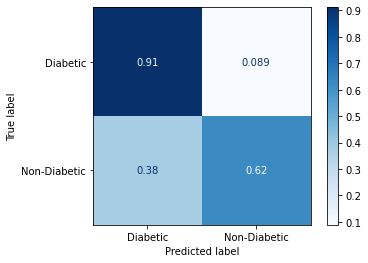

In [46]:
rf1 = RandomForestClassifier(max_depth=9, max_features=None, max_leaf_nodes=6, n_estimators=150, bootstrap=True)
rf1.fit(X_train,y_train)
y_pred = rf1.predict(X_test)
print(classification_report(y_pred,y_test))
print(accuracy_score(y_pred,y_test))
plot_confusion_matrix(rf1,X_test,y_test,display_labels=["Diabetic","Non-Diabetic"],cmap=plt.cm.Blues)
plot_confusion_matrix(rf1,X_test,y_test,display_labels=["Diabetic","Non-Diabetic"],cmap=plt.cm.Blues,normalize='true')

**Conclusie Random forest classifier**

Het classificatiemodel vertoont een redelijke prestatie, met een hoge precisie voor klasse 0 en een goede recall voor klasse 1, resulterend in een algemene nauwkeurigheid van 76%. Het model lijkt beter te zijn in het identificeren van negatieve gevallen dan positieve gevallen, en de keuze voor gebruik ervan hangt af van de specifieke prioriteiten en eisen van het probleem dat wordt opgelost.

## Gradient boosting

In [47]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [48]:
Gboost = GradientBoostingClassifier(random_state=0)
Gboost.fit(X_train,y_train)
y_pred = Gboost.predict(X_test)
print(classification_report(y_pred,y_test))
print("GradientBoostingClassifier:>",accuracy_score(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.90      0.82      0.86       111
           1       0.62      0.77      0.69        43

    accuracy                           0.81       154
   macro avg       0.76      0.79      0.77       154
weighted avg       0.82      0.81      0.81       154

GradientBoostingClassifier:> 0.8051948051948052


**Wat is Gradient Boosting?**

*Gradient Boosting is een machine learning-algoritme dat wordt gebruikt voor zowel classificatie- als regressieproblemen. Het werkt volgens het principe dat meerdere zwakke leerders (bijvoorbeeld ondiepe bomen) samen een nauwkeurigere voorspeller kunnen maken.* (Gaurav, 2022)


**Hoe werkt Gradient Boosting?**

Gradient Boosting is een krachtig boosting-algoritme dat meerdere zwakke leerders combineert tot sterke leerders, waarbij elk nieuw model wordt getraind om de verliesfunctie, zoals de gemiddelde kwadratische fout of kruis-entropie, van het vorige model te minimaliseren met behulp van gradiëntafdaling. In elke iteratie berekent het algoritme de gradiënt van de verliesfunctie ten opzichte van de voorspellingen van het huidige ensemble en traint vervolgens een nieuw zwak model om deze gradiënt te minimaliseren. De voorspellingen van het nieuwe model worden vervolgens toegevoegd aan het ensemble, en dit proces wordt herhaald totdat een stopcriterium is bereikt. (GeeksforGeeks, 2023)

In tegenstelling tot AdaBoost worden de gewichten van de trainingsvoorbeelden niet aangepast; in plaats daarvan wordt elk voorspellingsmodel getraind met behulp van de resterende fouten van de voorgaande modellen als labels. Er is een techniek genaamd Gradient Boosted Trees waarvan de basisleerder CART (Classification and Regression Trees) is. De onderstaande diagram legt uit hoe gradient-boosted trees worden getraind voor regressieproblemen. 

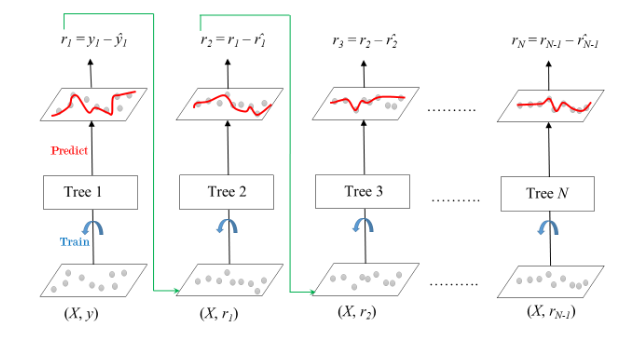

Gradient Boosting is een machine learning-techniek die bekend staat om zijn krachtige voorspellende prestaties, vooral bij het werken met 'tree based modellen' zoals beslissingsbomen (decision trees) en willekeurige bossen (random forests). Laten we eens kijken hoe de prestaties van Gradient Boosting zich verhouden tot deze andere twee veelgebruikte tree-based modellen:

**Decision Trees**:
Beslissingsbomen zijn eenvoudig te begrijpen en te interpreteren omdat ze bestaan uit een reeks eenvoudige beslissingsregels.
Ze hebben de neiging om te veel overfitting te veroorzaken, vooral als ze diep zijn. Dit betekent dat ze vaak goed presteren op trainingsgegevens, maar slecht generaliseren naar nieuwe, ongeziene gegevens.
De prestaties van beslissingsbomen kunnen aanzienlijk verbeteren door technieken zoals 'pruning' en het beperken van de diepte van de boom.
Over het algemeen zijn beslissingsbomen de minst krachtige van de drie modellen, maar ze zijn nuttig voor eenvoudige taken of als basislijnmodellen.

**Random Forests**:
Random Forests zijn enkele van de meest robuuste en populaire tree-based modellen.
Ze bouwen meerdere beslissingsbomen en combineren hun voorspellingen door middel van 'bagging' (bootstrap aggregating) en gemiddelde of meerderheidsstemming.
Dit vermindert overfitting in vergelijking met individuele beslissingsbomen en leidt tot betere generalisatieprestaties.
Random Forests presteren over het algemeen goed en kunnen worden gebruikt voor verschillende toepassingen zonder al te veel fine-tuning.

**Gradient Boosting**:
Gradient Boosting is een ensemble-techniek die ook gebruikmaakt van beslissingsbomen als basislearners.
Het verschilt van Random Forests doordat het sequentieel beslissingsbomen bouwt en zich richt op het corrigeren van de fouten die door eerdere bomen zijn gemaakt.
Hierdoor kunnen Gradient Boosting-modellen zeer krachtige voorspellingen doen en de prestaties van Random Forests vaak overtreffen.

Gradient Boosting vereist echter meer fine-tuning en is gevoeliger voor overfitting als het niet correct wordt geconfigureerd.
Samenvattend, Gradient Boosting heeft de potentie om betere prestaties te leveren dan zowel beslissingsbomen als Random Forests, maar het vereist meer aandacht voor hyperparameter-tuning en kan gevoeliger zijn voor overfitting. Het juiste model hangt af van de specifieke dataset en het doel van de voorspelling. Voor snelle prototyping en robuuste prestaties zijn Random Forests vaak een goede keuze, terwijl Gradient Boosting wordt gebruikt wanneer maximale nauwkeurigheid nodig is en er voldoende tijd is voor fine-tuning.*(ChatGPT, 2023, prompt 1: Gradient Boosting vs Tree Models)*

**Bepaal bij welke hyperparameters het model de beste resultaten geeft op de
gekozen metric.**

In [49]:
param_grid = { 
"loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }

In [50]:
random_search = RandomizedSearchCV(GradientBoostingClassifier(), 
                                   param_grid) 
random_search.fit(X_train, y_train) 
print(random_search.best_estimator_) 

GradientBoostingClassifier(max_depth=5, max_features='sqrt',
                           min_samples_leaf=0.13636363636363638,
                           min_samples_split=0.42727272727272736,
                           n_estimators=10, subsample=0.9)


              precision    recall  f1-score   support

           0       0.94      0.78      0.85       122
           1       0.49      0.81      0.61        32

    accuracy                           0.79       154
   macro avg       0.72      0.80      0.73       154
weighted avg       0.85      0.79      0.80       154

GradientBoostingClassifier:> 0.7857142857142857


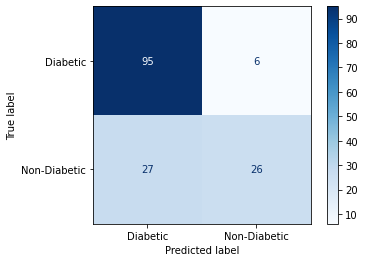

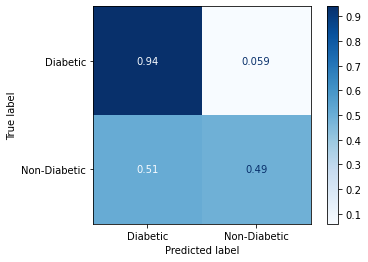

In [54]:
Gboost1 = GradientBoostingClassifier(learning_rate=0.2, max_depth=5, max_features='log2',
                           min_samples_leaf=0.24545454545454548,
                           min_samples_split=0.42727272727272736,
                           n_estimators=10, subsample=0.8)
Gboost1.fit(X_train,y_train)
y_pred = Gboost1.predict(X_test)
print(classification_report(y_pred,y_test))
print("GradientBoostingClassifier:>",accuracy_score(y_pred,y_test))


plot_confusion_matrix(Gboost1,X_test,y_test,display_labels=["Diabetic","Non-Diabetic"],cmap=plt.cm.Blues)
plot_confusion_matrix(Gboost1,X_test,y_test,display_labels=["Diabetic","Non-Diabetic"],cmap=plt.cm.Blues,normalize='true')

**Leg uit welke vormen van pruning zijn toegepast en wat het resultaat ervan was.**

Het proces van **pruning** kan worden onderverdeeld in twee soorten, namelijk **pre-pruning** en **post-pruning**.

**Pre-pruning** procedures voorkomen dat de volledige inductie van de trainingsset plaatsvindt door een stopcriterium te gebruiken in het inductie-algoritme, zoals bijvoorbeeld de maximale boomdiepte of informatiewinst (Attribuut)> minimale winst. Pre-pruning methoden worden als efficiënter beschouwd omdat ze geen volledige set induceren, maar in plaats daarvan blijven de bomen vanaf het begin klein. Pre-pruning methoden hebben echter vaak te maken met een gemeenschappelijk probleem, het horizon-effect. Hierbij wordt de ongewenste vroegtijdige beëindiging van de inductie bedoeld door het stopcriterium. *Pearl, Judea (1984)*

**Post-pruning** is de meest gebruikelijke manier om bomen te vereenvoudigen. Hierbij worden knooppunten en subtakken vervangen door bladeren om de complexiteit te verminderen. Snoeien kan niet alleen de grootte van de boom aanzienlijk verminderen, maar ook de classificatie-accuraatheid van niet-geziene objecten verbeteren. Het kan voorkomen dat de nauwkeurigheid van de toewijzing op de trainingsset verslechtert, maar de nauwkeurigheid van de classificatie-eigenschappen van de boom als geheel verbetert.

Deze procedures worden onderscheiden op basis van hun benadering in de boom (top-down of bottom-up).

**Bottom-up pruning** begint bij het laatste knooppunt in de boom (het laagste punt). Ze bepalen recursief van onder naar boven de relevantie van elk individueel knooppunt. Als de relevantie voor de classificatie niet aanwezig is, wordt het knooppunt verwijderd of vervangen door een blad. Het voordeel is dat met deze methode geen relevante subbomen verloren gaan. Voorbeelden van deze methoden zijn Reduced Error Pruning (REP), Minimum Cost Complexity Pruning (MCCP) of Minimum Error Pruning (MEP). *Mansour, Y. (1997)*

**Top-down snoeien** daarentegen begint bij de wortel van de boom. Ze voeren een relevantiecontrole uit langs de structuur hieronder, wat bepaalt of een knooppunt relevant is voor de classificatie van alle n items of niet. Door de boom op een intern knooppunt te snoeien, kan het gebeuren dat een hele subboom (ongeacht de relevantie) wordt verwijderd. Een van deze benaderingen is pessimistisch fouten snoeien (PEP), die goede resultaten oplevert bij niet-geziene items.
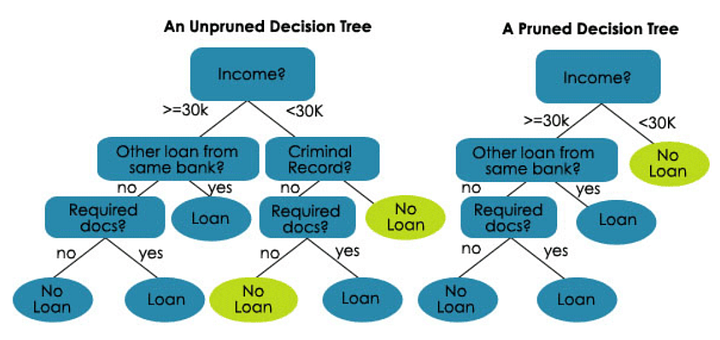

## Opdracht 3 - Bevindingen


## Opdracht 4 - Conclusie en aanbevelingen


## Referentielijst

- Lok, L. (2022). Decision trees, random forests and gradient boosting: What’s the difference? Leon Lok. https://leonlok.co.uk/blog/decision-trees-random-forests-gradient-boosting-whats-the-difference/#:~:text=The%20main%20difference%20between%20random,is%20built%20one%20after%20another


- Agrawal, S. K. (2023). Metrics to evaluate your classification model to take the right decisions. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2021/07/metrics-to-evaluate-your-classification-model-to-take-the-right-decisions/


- Gaurav. (2022). An introduction to gradient boosting decision trees. Machine Learning Plus. https://www.machinelearningplus.com/machine-learning/an-introduction-to-gradient-boosting-decision-trees/


- Yiu, T. (2021, 10 december). Understanding random Forest - towards data science. Medium. https://towardsdatascience.com/understanding-random-forest-58381e0602d2


- Donges, N. (2021). Random Forest: A complete guide for machine learning. Built In. https://builtin.com/data-science/random-forest-algorithm


- Bajaj, A. (2023). Performance Metrics in Machine Learning [Complete Guide]. neptune.ai. https://neptune.ai/blog/performance-metrics-in-machine-learning-complete-guide


- Great Learning Team. (2023, 30 mei). An introduction to GridSearchCV | What is Grid Search | Great Learning. Great Learning Blog: Free Resources what Matters to shape your Career! https://www.mygreatlearning.com/blog/gridsearchcv/


- GeeksforGeeks. (2023). Gradient boosting in ML. GeeksforGeeks. https://www.geeksforgeeks.org/ml-gradient-boosting/



- (ChatGPT, 2023, prompt 1: Gradient Boosting vs Tree Models.https://chat.openai.com/share/b15ebf3c-160c-4426-8927-8ad75e32db78


- Determining whether a dataset is imbalanced or not. (z.d.). Data Science Stack Exchange. https://datascience.stackexchange.com/questions/122571/determining-whether-a-dataset-is-imbalanced-or-not#:~:text=However%2C%20a%20common%20rule%20of,it%20can%20be%20considered%20imbalanced


- Pearl, J. (1984). Heuristics: Intelligent Search Strategies for Computer Problem Solving. Addison Wesley Publishing Company.


- Mansour, Y. (1997). "Pessimistic decision tree pruning based on tree size". Proc. 14th International Conference on Machine Learning. pp. 195–201